## The `Matvec` abstraction for solving PDEs with FEM

Continuous Galerkin, discontinuous Galerkin, and SEM are some of the many flavors of FEM. Many of these implementations utilize similar "boilerplate" mathematical operations to setup and solve PDEs. The "boilerplate" operations that immediately come to mind:
1. Gather-scatter
2. Interpolation to/projection from a quadrature domain

To describe this mathematically, suppose we have the following ingredients:
1. An operator $A$. Typically the entries of $A$ are inner products of basis functions, like $A_{ij}$ = $\int_{\Omega} \phi_i \phi_j d\Omega$, possibly with derivatives on either or both basis functions.
2. Global degrees-of-freedom (DOFs) $u$
3. An operator $E$ such that element-local DOFs are given by $u_{\ell} = Eu$ and $u = E^T u_{\ell}$ gets us back to global DOFs

We can apply the *global* operator $A^G$ as
$$
A^G u = E^T A E u.
$$

This operation is similar to another, somewhat more complicated operation, where we first interpolate our global DOFs to a quadrature domain before applying the operator $A$. After we apply $A$, we project our result back. Specifically, given a set of basis functions $\{\phi_i\}_{i=0}^N$, where $N$ is our desired polynomial order, and a set of quadrature nodes $\{\xi_k\}_{k=0}^{N_q}$ we first construct a Vandermonde matrix $V_{ij} = \phi_j(\xi_i)$. Then, we perform the following operation:
$$
A^G u = E^T V^T A V E u.
$$

Regardless of the FEM implementation, we are likely going to be required to perform gather-scatter, interpolation/projection, or both.

This tutorial will cover how to use a package called `discr-tools` to setup and solve Poisson's equation.

## `discr-tools`
`discr-tools` is a Python library that can be used to solve PDEs. Right now, it is capable of solving problems without a time dimension, but eventually timesteppers will be added.

There are two key abstractions in the `discr-tools` library, `Discretization`s and `Matvec`s. We'll introduce both here.

## `Discretization`s
For all intents and purposes, `Discretization`s are dataclasses that hold discretization-specific information. Let's take a look:

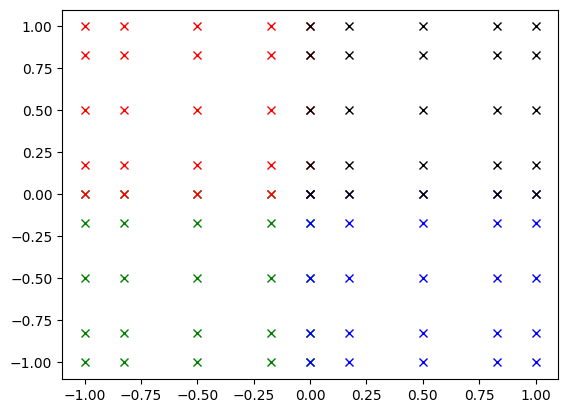

In [36]:
import matplotlib.pyplot as plt
from discr_tools.discretization import Discretization

# define an interval over which we'll construct a box mesh
a, b = -1, 1
dim = 2
order = 4
nelts_1d = 2

discr = Discretization(order, a, b, nelts_1d, dim)

# by default, a tensor-product of GLL nodes is mapped to each element
x, y = discr.mapped_elements
colors = ['g', 'r', 'b', 'k']
for ielt in range(discr.nelts):
    plt.plot(x[ielt], y[ielt], 'x', c=colors[ielt])

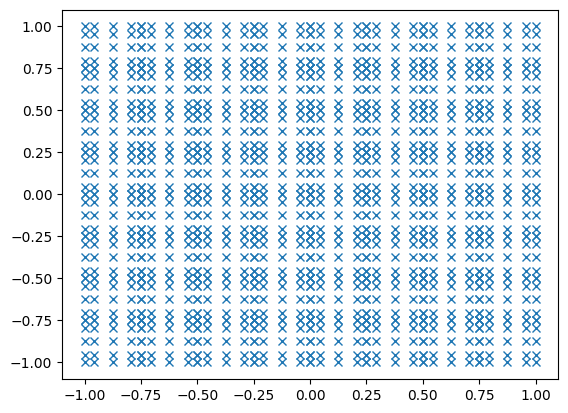

In [37]:
# bumping up the element count
nelts_1d = 8
discr = Discretization(order, a, b, dim, nelts_1d)
x, y = discr.mapped_elements
plt.plot(x, y, 'x', c='tab:blue');

### Try it yourself:

Create an order 4 3D discretization on $[0, 1]$ with 4 elements per axis.

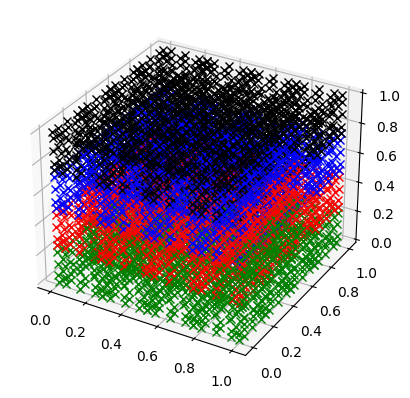

In [38]:
discr = Discretization(4, 0, 1, 3, 4) # clear

x, y, z = discr.mapped_elements
ax = plt.axes(projection='3d')
for ielt in range(discr.nelts):
    plt.plot(x[ielt], y[ielt], z[ielt], 'x', c=colors[ielt % 4])

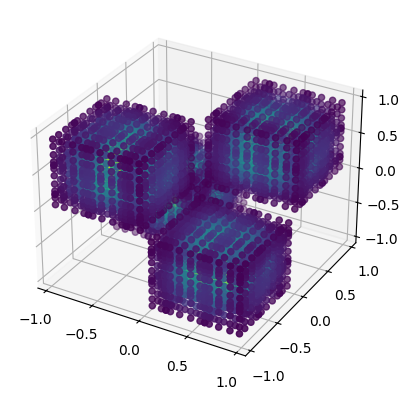

In [39]:
import numpy as np

discr = Discretization(5, -1, 1, 3, 5)
x, y, z = discr.mapped_elements

# functions can be called directly on x, y, z
f = np.sin(np.pi*x)*np.sin(np.pi*y)*np.sin(np.pi*z)

f_idxs = np.where(f > 1e-12)  # change this to find all indices where f > 1e-12
x = x[f_idxs]
y = y[f_idxs]
z = z[f_idxs]

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=f[f_idxs])

# shared DOFs = 5


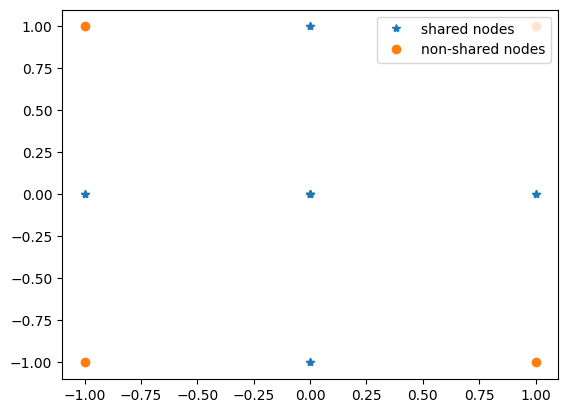

In [40]:
# gather and scatter are built-in to the Discretization class
order = 1     # change this to alter the number of shared DOFs
a, b = -1, 1
dim = 2
nelts_1d = 2  # change this to alter the number of shared DOFs

discr = Discretization(order, a, b, dim, nelts_1d)

print(
    f"# shared DOFs = {np.sum(
        discr.scatter(np.ones_like(discr.mapped_elements[0])) > 1)}")

gathered_ones = discr.gather(discr.scatter(np.ones_like(discr.mapped_elements[0])))
x, y = discr.mapped_elements


shared_indices = np.where(gathered_ones > 1)
non_shared_indices = np.where(gathered_ones == 1)
plt.plot(
    x[shared_indices], 
    y[shared_indices], '*', label='shared nodes')
plt.plot(
    x[non_shared_indices], 
    y[non_shared_indices], 'o', label='non-shared nodes', zorder=-5)
plt.legend()

## `Matvec`s

The `Matvec` abstraction is designed to make it so a user does not have to explicitly call gather or scatter to perform a solve. First, we'll look at what someone would need to do if this did not exist. We'll solve Poisson, so
$$
-\Delta u = f, \quad u(x) = 0\quad x \in \partial\Omega,
$$
with domain $\Omega = [-1, 1]^2$ and boundary $\partial\Omega$.

Going through all the steps to conver this to weak form, we wind up with the following statement:
$$
\sum_{j=0}^N u_j \int_{\Omega} \nabla \phi_j \cdot \nabla \phi_i d\Omega = \int_{\Omega} f\phi_i d\Omega.
$$

We won't go into too much detail about the math here, but for completeness we'll use a Lagrange basis based on Gauss-Lobatto-Legendre (GLL) nodes and the quadrature rule associated with the GLL nodes to solve the problem.

We'll evaluate our derivatives and integrals on a reference domain, then map the results to the physical domain using an affine map $\psi$ that has already been applied (that's where the `discr.mapped_elements` came from!).

The full expression we'll be responsible for defining to solve our problem will be
$$
\sum_{j=0}^N u_j \int_{\Omega} (J^{-T} \tilde\nabla\phi_j) \cdot (J^{-T} \tilde\nabla\phi_i) |J| d\Omega.
$$
Looks terrible, but it isn't so bad. Note that $\tilde\nabla\phi_i$ is just $D = \begin{bmatrix} D_r, D_s, D_t \end{bmatrix}^T$, where $D_r$ is an operator that computes the partial derivative corresponding to the $r$ reference axis. Since we're using Lagrange polynomials, the entries are simply the derivatives of the basis functions in the $r, s, t$ directions.

Normally, we'd also have to specify gather-scatter operations. However, with the `Matvec` class we can avoid all of that. 

---

At its core, the `Matvec` class really is just a way of applying some matrix to a DOF vector. The implementations need to return a callable that take a single argument. Here's a simple example:

In [41]:
import numpy as np
from discr_tools.matvecs import MatvecBase

class MyMatvec(MatvecBase):
    def cpu_matvec(self):
        def matvec(u):
            nelts, npts = u.shape
            return np.einsum("ij,ej->ei", np.random.randn(npts, npts), u)
        return matvec

    def gpu_matvec(self):
        pass

discr = Discretization(3, -1, 1, 2, 2)
u = np.ones_like(discr.nodes[0])

mv = MyMatvec(discr)
mv(u)  # gather -> apply matvec -> apply boundary mask -> scatter

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        -2.99014025,   0.        ,   1.05854069,   3.94520036,
         1.05854069,   3.94520036,   0.        ,  -3.11875969,
        -0.30393314, -12.44060179,  -3.11875969,  -0.30393314,
         0.        ,   0.        ,   4.52337943,   1.2483953 ,
        -2.7146412 ,   4.52337943,   1.2483953 ,   0.        ,
         0.        ,   1.05854069,   3.94520036,  -2.99014025,
         1.05854069,   3.94520036,   0.        ,  -3.11875969,
        -0.30393314,  -3.11875969,  -0.30393314,   0.        ,
       -12.44060179,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

In [42]:
# define an order 4 discretization with 5 elements per axis on [-1, 1]^2
discr = Discretization(4, -1, 1, 2, 5)

# geometric and scaling factors can be automatically computed via helper routines
from discr_tools.geometry import inverse_jacobian_t, jacobian_determinant
det_j = jacobian_determinant(discr.mapped_elements, discr.basis_cls)
inv_j_t = inverse_jacobian_t(discr.mapped_elements, discr.basis_cls)

# reference operators are predefined in the Discretization object
d = discr.operators.diff_operator

# by default the operators are the 1D versions since discr_tools is a 
# tensor-product element only endeavour, but for now we'll do the inefficient
# thing and compute the full operator
eye = np.eye(5)
dr = np.kron(d, eye)
ds = np.kron(eye, d)
d = np.array([dr, ds])

# finally, we need quadrature weights which are supplied by the Discretization
wts = discr.basis_cls.weights
wts_2d = np.kron(wts, wts)

g = np.einsum("kiep,kjep,ep,p->ijep", inv_j_t, inv_j_t, det_j, wts_2d)

# now we'll define a simple Poisson matvec, an improved version + GPU version is
# implemented in the next notebook
class MyPoissonMatvec(MatvecBase):
    def cpu_matvec(self):

        # make one long expression (not suggested for performance!)
        def matvec(u):
            ur = np.einsum("ij,ej->ei", dr, u)
            us = np.einsum("ij,ej->ei", ds, u)

            ux = g[0,0] * ur + g[0,1] * us
            uy = g[1,0] * ur + g[1,1] * us

            uxx = np.einsum("ji,ej->ei", dr, ux)
            uyy = np.einsum("ji,ej->ei", ds, uy)

            return uxx + uyy

        return matvec

    def gpu_matvec(self):
        pass

In [43]:
import sympy as sp
import scipy.sparse.linalg as spla


# define a RHS
x, y = discr.mapped_elements

x_sp = sp.symbols('x0 x1')

u_expr = 1.
for i in range(dim):
    u_expr *= sp.sin(sp.pi*x_sp[i])
u_lambda = sp.lambdify(x_sp, u_expr)

lap_u_expr = 0.
for i in range(dim):
    lap_u_expr += u_expr.diff(x_sp[0], 2)
lap_u_expr = -lap_u_expr
lap_u_lambda = sp.lambdify(x_sp, lap_u_expr)

rhs = lap_u_lambda(x, y)

f = discr.scatter(discr.apply_mask(det_j * rhs * wts_2d))

# define a scipy LinearOperator and use it to solve Poisson with the matvec above 
# and conjugate gradient

mv = MyPoissonMatvec(discr)
lin_op = spla.LinearOperator(f.shape*2, mv)

out, _ = spla.cg(lin_op, f)
out = discr.gather(out)

u_true = u_lambda(x, y)

abs_err = abs(out - u_true)
l2_abs = np.sqrt(np.sum(abs_err**2 * det_j * wts_2d))
l2_u = np.sqrt(np.sum(u_true**2 * det_j * wts_2d))
l2_err = l2_abs / l2_u
print(f"Error: {l2_err}")

Error: 6.3943176156584e-06


## That's it for this notebook. The next notebook will consider GPU matvecs!